# BERT: Pre-training of Deep Bidirectional Transformers Language Understanding

## 1. Libraries

In [3]:
import os
import re
import math
from typing import List

import spacy
import torch
import torchtext
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader


# Controlling the randomness in PyTorch and NumPy.
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.benchmark = True
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

## 2. The Dataset

### 2.1. Reading the raw dataset

In [4]:
BASE_DATASET_PATH = os.path.join(
    "..", 
    "..", 
    "nlp", 
    "datasets", 
    "en-question-answer"
)
S08_FILENAME = "S08_question_answer_pairs.txt"
S09_FILENAME = "S09_question_answer_pairs.txt"
S10_FILENAME = "S10_question_answer_pairs.txt"

s08_df = pd.read_csv(os.path.join(BASE_DATASET_PATH, S08_FILENAME), delimiter="\t")
s09_df = pd.read_csv(os.path.join(BASE_DATASET_PATH, S09_FILENAME), delimiter="\t")
s10_df = pd.read_csv(os.path.join(BASE_DATASET_PATH, S10_FILENAME), delimiter="\t", encoding="latin")

df = pd.concat([s08_df, s09_df, s10_df])
df.head()

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,S08_set3_a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,S08_set3_a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,S08_set3_a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,S08_set3_a4
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,S08_set3_a4


### 2.2. Initializing The SpaCy English Tokenizer

In [5]:
en_tokenizer = get_tokenizer("spacy", "en_core_web_sm")

### 2.3. Removing *NaN* valued rows (ror the 'Question' and 'Answer' columns)

In [6]:
df = df[df["Answer"].notna()]
print("Are there any NaN values in 'Question':", df["Answer"].isnull().any().any())
print("Are there any NaN values in 'Answer':", df["Answer"].isnull().any().any())

Are there any NaN values in 'Question': False
Are there any NaN values in 'Answer': False


### 2.4. Choosing the maximum sizes based on the distributions of 'Questions' And 'Answers'

In [7]:
df["Question Size"] = df["Question"].apply(lambda x: len(en_tokenizer(str(x))))
df["Answer Size"] = df["Answer"].apply(lambda x: len(en_tokenizer(str(x))))
df.head()

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile,Question Size,Answer Size
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,S08_set3_a4,11,1
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,S08_set3_a4,11,2
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,S08_set3_a4,10,1
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,S08_set3_a4,10,2
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,S08_set3_a4,7,1


array([[<AxesSubplot:title={'center':'Question Size'}>,
        <AxesSubplot:title={'center':'Answer Size'}>]], dtype=object)

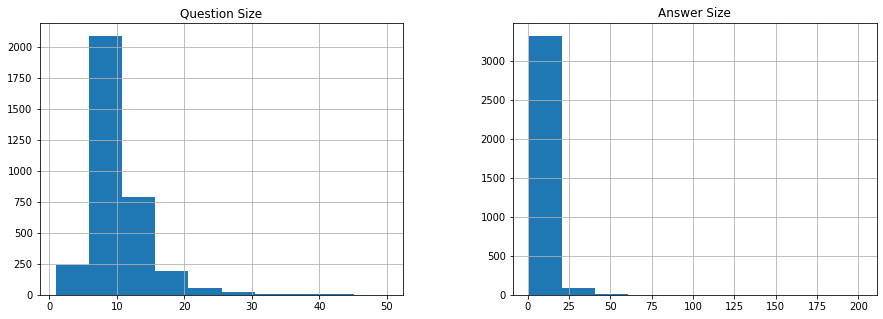

In [8]:
df[["Question Size", "Answer Size"]].hist(figsize=(15, 5))

As we can see it would be okay to choose maxmimum question size of $20$ and maximum answer size of $30$.

### 2.5. Creating a vocabulary

In [11]:
def pad_sequence(tokens, max_len):
    if len(tokens) >= max_len:
        tokens = tokens[:max_len]
    else:
        len_diff = max_len - len(tokens)
        tokens = tokens + ["<pad>"] * len_diff

    return tokens


def iterate_corpus(
    questions: List, answers: List, 
    q_max_len: int, a_max_len: int, 
    tokenizer: spacy.tokenizer.Tokenizer
):
    for q, a in zip(questions, answers):
        q_tokens = tokenizer(q)
        a_tokens = tokenizer(a)

        q_tokens = pad_sequence(q_tokens, q_max_len)
        a_tokens = pad_sequence(a_tokens, a_max_len)

        yield ["<cls>"] + q_tokens + ["<sep>"] + a_tokens + ["<sep>"]


SPECIALS = ["<pad>", "<sep>", "<cls>"]
Q_MAX_LEN = 20
A_MAX_LEN = 30


vocab = build_vocab_from_iterator(
    iterate_corpus(
        df["Question"].tolist(),
        df["Answer"].tolist(),
        Q_MAX_LEN,
        A_MAX_LEN,
        en_tokenizer
    ), 
    specials=SPECIALS
)
print("Vocab created!")

Vocab created!


### 2.6. Creating a PyTorch Dataset

In [36]:
# TODO: Create the Q&A dataset
class QuestionsAnswersDataset(Dataset):

    def __init__(
        self,
        questions: List,
        answers: List,
        q_max_size: int,
        a_max_size: int,
        tokenizer,
        vocab
    ):
        self.q_max_size = q_max_size
        self.a_max_size = a_max_size
        self.tokenizer = tokenizer
        self.vocab = vocab
    
        self.x, self.y = self._get_inout_tensors(questions, answers)

    def __getitem__(self, idx):
        pass

    def __len__(self):
        pass

    def _get_inout_tensors(self, questions: List, answers: List):
        

        for q, a in zip(questions, answers):
            q_tokens = self.tokenizer(q)
            a_tokens = self.tokenizer(a)
            
            q_tokens = pad_sequence(q_tokens, self.q_max_len)
            a_tokens = pad_sequence(a_tokens, self.a_max_len)
            
            input_sequence = ["<cls>"] + q_tokens + ["<sep>"] + a_tokens + ["<sep>"]

            

questions = df["Question"].tolist()
answers = df["Answer"].tolist()

QuestionsAnswersDataset(questions=questions, answers=answers)

['Was Abraham Lincoln the sixteenth President of the United States?', 'Was Abraham Lincoln the sixteenth President of the United States?', 'Did Lincoln sign the National Banking Act of 1863?', 'Did Lincoln sign the National Banking Act of 1863?', 'Did his mother die of pneumonia?', 'Did his mother die of pneumonia?', "How many long was Lincoln's formal education?", "How many long was Lincoln's formal education?", 'When did Lincoln begin his political career?', 'When did Lincoln begin his political career?']
['yes', 'Yes.', 'yes', 'Yes.', 'no', 'No.', '18 months', '18 months.', '1832', '1832.']


## 3. BERT

In [19]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)

        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(0)]
        
        return self.dropout(x)

In [23]:
class BERT(nn.Module):
    
    def __init__(
        self, 
        d_model, nheads, num_layers,
        vocab_size,
        padding_index=0,
        dropout=0.1
    ):
        super().__init__()

        assert d_model % nheads == 0, "'d_model' has to be divisible by 'nheads'."

        # Token embedding
        self.token_embed = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=d_model, 
            padding_idx=padding_index
        )

        # Segmentation embedding
        # The difference here is that we are setting 'num_embeddings' to 3 because
        # we will use 0 as padding index, 1 as sent1 index and 2 as sent2 index.
        self.segm_embed = nn.Embedding(
            num_embeddings=3, embedding_dim=d_model, 
            padding_idx=padding_index
        )

        # Positional embedding
        self.pos_embed = PositionalEncoding(
            d_model, dropout
        )

        # Dropout after all embeddings
        self.dropout = nn.Dropout(p=dropout)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nheads, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer=enc_layer, num_layers=num_layers
        )

    def forward(self, x, segmentations):
        # Input embedding
        x = self.token_embed(x)
        x += self.segm_embed(segmentations)
        x += self.pos_embed(x)

        out = self.encoder(self.dropout(x))

        return out

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)


model = BERT(
    d_model=64,
    nheads=8,
    num_layers=2,
    vocab_size=100
)

x = torch.randint(low=0, high=99, size=(2, 5))
segmentations = torch.randint(low=0, high=3, size=(2, 5))

print("Input shape:", x.shape)
print("Segmentations shape:", segmentations.shape)
x = model(x, segmentations)
print("Output shape:", x.shape)

Input shape: torch.Size([2, 5])
Segmentations shape: torch.Size([2, 5])
Output shape: torch.Size([2, 5, 64])
